<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving photo-1501594907352-04cda38ebc29.jfif to photo-1501594907352-04cda38ebc29.jfif

Upload Style Image


Saving stained-glass-abstract-drawing-randomly-arranged-geometric-shapes-stained-glass-abstract-drawing-99831603.jpg to stained-glass-abstract-drawing-randomly-arranged-geometric-shapes-stained-glass-abstract-drawing-99831603.jpg
Content Path: <_io.BytesIO object at 0x7eff3d1e6f40>
Style Path: <_io.BytesIO object at 0x7eff3d25e4a0>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


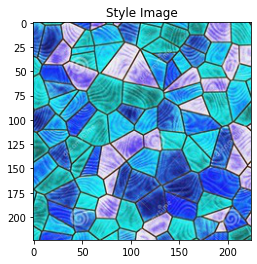

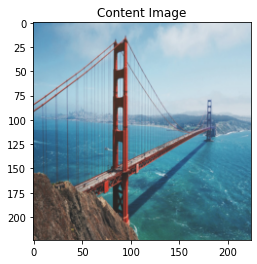

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**
* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image


In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = mean.view(-1, 1, 1)
      self.std = std.view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    # self.vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
# choices = [layer for layer in vgg_names if layer[0]=='c' and layer[-1]=='1']
choices = [i for i, element in enumerate(vgg_names) if element[0] == 'c' and element[-1] == '1'][:-1]
c_layer = 10

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
model_content = VGGIntermediate([c_layer])
model_content = model_content.eval().cuda()

model_style = VGGIntermediate(choices)
model_style = model_style.eval().cuda()

# Cache the outputs of the content and style layers for their respective images
content_outputs = model_content(content_image)
style_outputs = model_style(style_image)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
choices

[0, 5, 10, 17]

___

### Part 2
Create a class for the style and content loss

**TODO:**

**DONE:**
* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class


In [8]:
def gram_matrix(input):
  input = torch.flatten(input.squeeze(0), start_dim=1)
  return torch.matmul(input, torch.transpose(input, 0, 1))
  
class ContentLoss(nn.Module):
  def __init__(self, outputs):
    super(ContentLoss, self).__init__()
    self.outputs = outputs.detach()

  def forward(self, statistics):
    # return the mean squared error of each set of statistics between 
    # the original statistics and those from the random image
    # return [0.5 * torch.sum(torch.square(orig - trans)) for orig, trans in zip(self.outputs.values(), statistics.values())]
    target = torch.flatten(torch.squeeze(self.outputs), 1)
    other = torch.flatten(torch.squeeze(statistics), 1)
    return 0.5 * torch.sum(torch.square(target - other))

    
class StyleLoss(nn.Module):
  def __init__(self, outputs):
    super(StyleLoss, self).__init__()
    self.outputs = outputs.detach()
    self.M = self.outputs.shape[2] * self.outputs.shape[3]

  def forward(self, statistics):
    # return the mean squared error of each set of statistics between
    # the original statistics and those from the random image
    # statistics = statistics.cuda()
    target = torch.flatten(torch.squeeze(self.outputs), 1)
    other = torch.flatten(torch.squeeze(statistics), 1)

    G = gram_matrix(other)
    N = G.shape[0]
    w = 5

    A = gram_matrix(target)
    E = torch.sum(torch.square(G - A)) / (4. * N**2 * self.M**2 * w)

    return E


    # G = [gram_matrix(L) for L in statistics.values()]
    # N = [a.shape[0] for a in G]
    # w = [1/5 for i in range(self.n)] 

    # A = [gram_matrix(a) for a in self.outputs.values()]
    # E = [torch.sum(torch.square(G[i] - A[i])) / (4 * N[i]**2 * self.M[i]**2) for i in range(self.n)]

    # return torch.sum(torch.FloatTensor([w[i] * E[i] for i in range(self.n)]))


# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
contentLosses = ContentLoss(content_outputs[c_layer])

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
styleLosses = [StyleLoss(a) for a in style_outputs.values()]

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**
* Use an Adam optimizer (try learning rate of .1)

**DONE:**

* Ensure that the outputs don't go out of range (clamp them)
* Show both the content and the style loss every 50 steps
* Display the tensor as an image!


In [12]:
# Start with a copy of the content image
generated = content_image.clone().detach()
generated.requires_grad_(True)
model_content.requires_grad_(False)
model_style.requires_grad_(False)
optimizer = optim.Adam([generated], lr=1e-1)
num_epoch = 2200
alpha, beta = 0.5, 5e4
c_loss_list = []
s_loss_list = []

In [13]:
# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 

def scope():
  try:
    gc.collect()
    print(torch.cuda.memory_allocated() / 1e9)
    
    val_acc = 0
    # loop = tqdm(total=1, position=0, leave=False)

    # Run your training and validation loop and collect stats
    for epoch in tqdm(range(num_epoch)):
      # Call your model, figure out loss and accuracy
      with torch.no_grad():
        generated.clamp_(0, 1)
      optimizer.zero_grad()
      gen_stats_c = model_content(generated)
      gen_stats_s = model_style(generated)

      # loseContent = contentLosses(gen_stats)
      loseContent = contentLosses(gen_stats_c[c_layer])
      loseStyle = [styleLosses[i](gen_stats_s[a]) for i, a in enumerate(choices)]
      loss = loseContent * alpha + sum(loseStyle) * beta
      loss.backward()

      # loop.set_description('epoch:{}, total loss:{:.4f}'.format(epoch, loss.item()))
      # loop.update(1)

      optimizer.step()

      if epoch % 50 == 0:
        print(f"Step: {epoch}", end="\t")
        # print(f"Content Loss: {loseContent.item()}", end="\t")
        print(f"Total Loss: {loss.item()}", end="\t")
        # print(f"Style Loss: {loseStyle.item()}")

      # loop.close()
    
    with torch.no_grad():
      generated.clamp_(0, 1)

  except:
    __ITB__()
    
scope()

0.177615872


  0%|          | 7/2200 [00:00<00:39, 55.31it/s]

Step: 0	Total Loss: 336302240.0	

  2%|▏         | 54/2200 [00:01<01:04, 33.36it/s]

Step: 50	Total Loss: 29766478.0	

  5%|▍         | 104/2200 [00:02<01:01, 33.82it/s]

Step: 100	Total Loss: 24844092.0	

  7%|▋         | 151/2200 [00:04<01:09, 29.63it/s]

Step: 150	Total Loss: 29347840.0	

  9%|▉         | 202/2200 [00:05<01:05, 30.39it/s]

Step: 200	Total Loss: 25257802.0	

 11%|█▏        | 252/2200 [00:06<01:03, 30.46it/s]

Step: 250	Total Loss: 26514518.0	

 14%|█▎        | 302/2200 [00:08<01:02, 30.49it/s]

Step: 300	Total Loss: 24030378.0	

 16%|█▌        | 352/2200 [00:09<01:01, 29.90it/s]

Step: 350	Total Loss: 25164216.0	

 18%|█▊        | 402/2200 [00:10<00:59, 30.22it/s]

Step: 400	Total Loss: 25365926.0	

 20%|██        | 451/2200 [00:12<01:00, 28.98it/s]

Step: 450	Total Loss: 26567366.0	

 23%|██▎       | 501/2200 [00:13<00:58, 28.99it/s]

Step: 500	Total Loss: 24486170.0	

 25%|██▌       | 551/2200 [00:14<00:57, 28.68it/s]

Step: 550	Total Loss: 24131528.0	

 27%|██▋       | 601/2200 [00:16<00:56, 28.54it/s]

Step: 600	Total Loss: 25848420.0	

 30%|██▉       | 651/2200 [00:17<00:54, 28.56it/s]

Step: 650	Total Loss: 25579948.0	

 32%|███▏      | 701/2200 [00:18<00:52, 28.47it/s]

Step: 700	Total Loss: 24721692.0	

 34%|███▍      | 751/2200 [00:20<00:51, 28.35it/s]

Step: 750	Total Loss: 24824740.0	

 36%|███▋      | 801/2200 [00:21<00:49, 28.37it/s]

Step: 800	Total Loss: 27724902.0	

 39%|███▊      | 851/2200 [00:23<00:47, 28.37it/s]

Step: 850	Total Loss: 23582616.0	

 41%|████      | 901/2200 [00:24<00:45, 28.35it/s]

Step: 900	Total Loss: 22427016.0	

 43%|████▎     | 951/2200 [00:25<00:44, 28.33it/s]

Step: 950	Total Loss: 23577022.0	

 46%|████▌     | 1001/2200 [00:27<00:42, 28.52it/s]

Step: 1000	Total Loss: 27130064.0	

 48%|████▊     | 1051/2200 [00:28<00:40, 28.25it/s]

Step: 1050	Total Loss: 24083636.0	

 50%|█████     | 1101/2200 [00:29<00:38, 28.37it/s]

Step: 1100	Total Loss: 24494060.0	

 52%|█████▏    | 1151/2200 [00:31<00:36, 28.68it/s]

Step: 1150	Total Loss: 26264050.0	

 55%|█████▍    | 1201/2200 [00:32<00:35, 28.28it/s]

Step: 1200	Total Loss: 24253580.0	

 57%|█████▋    | 1251/2200 [00:34<00:33, 28.53it/s]

Step: 1250	Total Loss: 24521348.0	

 59%|█████▉    | 1301/2200 [00:35<00:31, 28.59it/s]

Step: 1300	Total Loss: 22121280.0	

 61%|██████▏   | 1351/2200 [00:36<00:29, 28.69it/s]

Step: 1350	Total Loss: 26331964.0	

 64%|██████▎   | 1401/2200 [00:38<00:27, 28.61it/s]

Step: 1400	Total Loss: 28894870.0	

 66%|██████▌   | 1451/2200 [00:39<00:25, 28.93it/s]

Step: 1450	Total Loss: 25923068.0	

 68%|██████▊   | 1501/2200 [00:40<00:24, 28.90it/s]

Step: 1500	Total Loss: 22015048.0	

 71%|███████   | 1552/2200 [00:42<00:21, 30.16it/s]

Step: 1550	Total Loss: 21598790.0	

 73%|███████▎  | 1601/2200 [00:43<00:20, 28.94it/s]

Step: 1600	Total Loss: 33197390.0	

 75%|███████▌  | 1652/2200 [00:44<00:18, 30.07it/s]

Step: 1650	Total Loss: 25372198.0	

 77%|███████▋  | 1702/2200 [00:46<00:16, 30.14it/s]

Step: 1700	Total Loss: 21681846.0	

 80%|███████▉  | 1752/2200 [00:47<00:14, 30.34it/s]

Step: 1750	Total Loss: 21450572.0	

 82%|████████▏ | 1802/2200 [00:48<00:13, 30.37it/s]

Step: 1800	Total Loss: 22457432.0	

 84%|████████▍ | 1852/2200 [00:50<00:11, 30.04it/s]

Step: 1850	Total Loss: 23679364.0	

 86%|████████▋ | 1902/2200 [00:51<00:09, 30.47it/s]

Step: 1900	Total Loss: 23469434.0	

 89%|████████▊ | 1952/2200 [00:52<00:08, 30.36it/s]

Step: 1950	Total Loss: 22923690.0	

 91%|█████████ | 2002/2200 [00:54<00:06, 30.53it/s]

Step: 2000	Total Loss: 22753164.0	

 93%|█████████▎| 2052/2200 [00:55<00:04, 30.75it/s]

Step: 2050	Total Loss: 25278468.0	

 96%|█████████▌| 2102/2200 [00:56<00:03, 30.74it/s]

Step: 2100	Total Loss: 24927568.0	

 98%|█████████▊| 2152/2200 [00:58<00:01, 30.28it/s]

Step: 2150	Total Loss: 29498508.0	

100%|██████████| 2200/2200 [00:59<00:00, 36.98it/s]


Text(0.5, 1.0, 'Generaged Image')

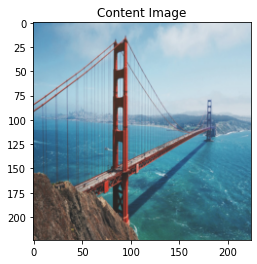

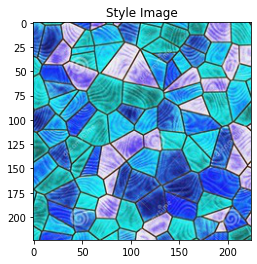

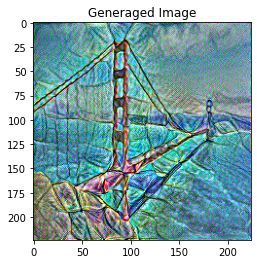

In [14]:
# Show the image
toPIL = transforms.ToPILImage()  

plt.figure()
plt.imshow(toPIL(content_image.cpu().clone().squeeze(0))) 
plt.title("Content Image")

plt.figure()
plt.imshow(toPIL(style_image.cpu().clone().squeeze(0))) 
plt.title("Style Image")

plt.figure()
plt.imshow(toPIL(generated.cpu().clone().squeeze(0))) 
plt.title("Generaged Image")

### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

(1) The loss value for the content is one half of the mean-squared error between the original content image and the generated image. That is, one half of the sum of squares of the difference between the pixels on the ith row and the jth column of the lth layer for the content and generated images.

(3) The gram matrix computes the inner product of the lth layer of the generated image with itself. That is, the value of the element of the ith row, jth column, and lth column of the gram matrix is the sum of the k products of the ith row and jth row of the lth layer of the generated image.

(4) The contribution of the lth layer to the total loss is the mean squared error between the original style image and the generated image times a scalor. The scalor is defined by the inverse of four times the number of rows in the lth layer of the generated image squared times the number of columns in the lth layer of the generated image squared. That is, one half of the sum of squares of the difference between the pixels on the ith row and the jth column of the lth layer for the style and generated images times this scalor.

(5) The total style loss is given by the sum of style losses at each layer times a weight factor of the contribution of that layer.




